<h1 style='text-align:center; color:blue;'> Healthcare Premium Prediction Model</h1>

## Import Libraries

In [171]:
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.linear_model import LinearRegression, ridge_regression,Ridge
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error,r2_score
import numpy as np
from xgboost import XGBRegressor
from sklearn.model_selection import RandomizedSearchCV

## Data Loading

In [172]:
df=pd.read_excel("premiums.xlsx")
df.head(5)

,Age,Gender,Region,Marital_status,Number Of Dependants,BMI_Category,Smoking_Status,Employment_Status,Income_Level,Income_Lakhs,Medical History,Insurance_Plan,Annual_Premium_Amount
0,26,Male,Northwest,Unmarried,0,Normal,No Smoking,Salaried,<10L,6,Diabetes,Bronze,9053
1,29,Female,Southeast,Married,2,Obesity,Regular,Salaried,<10L,6,Diabetes,Bronze,16339
2,49,Female,Northeast,Married,2,Normal,No Smoking,Self-Employed,10L - 25L,20,High blood pressure,Silver,18164
3,30,Female,Southeast,Married,3,Normal,No Smoking,Salaried,> 40L,77,No Disease,Gold,20303
4,18,Male,Northeast,Unmarried,0,Overweight,Regular,Self-Employed,> 40L,99,High blood pressure,Silver,13365


### Check shape of data

In [173]:
df.shape

(50000, 13)

### Convert columns into lower case

In [174]:
df.columns=df.columns.str.replace("_", " ").str.lower()
df.columns=df.columns.str.replace(" ", "_").str.lower()

## Exploratory Data-analysis and data cleaning

### Handle Missing value

In [175]:
df.isna().sum()

age                       0
gender                    0
region                    0
marital_status            0
number_of_dependants      0
bmi_category              0
smoking_status           11
employment_status         2
income_level             13
income_lakhs              0
medical_history           0
insurance_plan            0
annual_premium_amount     0
dtype: int64

In [176]:
df.dropna(inplace=True)

In [177]:
df.shape

(49976, 13)

In [178]:
df.isna().sum()

age                      0
gender                   0
region                   0
marital_status           0
number_of_dependants     0
bmi_category             0
smoking_status           0
employment_status        0
income_level             0
income_lakhs             0
medical_history          0
insurance_plan           0
annual_premium_amount    0
dtype: int64

### Handle Duplicate values

In [179]:
df.drop_duplicates(inplace=True)
df.duplicated().sum()

np.int64(0)

In [180]:
df.describe()

,age,number_of_dependants,income_lakhs,annual_premium_amount
count,49976.000000,49976.000000,49976.000000,49976.000000
mean,34.591764,1.711842,23.021150,15766.810189
std,15.000378,1.498195,24.221794,8419.995271
min,18.000000,-3.000000,1.000000,3501.000000
25%,22.000000,0.000000,7.000000,8607.750000
50%,31.000000,2.000000,17.000000,13928.000000
75%,45.000000,3.000000,31.000000,22273.500000
max,356.000000,5.000000,930.000000,43471.000000


#### Data Cleaning: number of dependants

In [181]:
df[df.number_of_dependants<0].shape

(72, 13)

In [182]:
df['number_of_dependants']=abs(df['number_of_dependants'])
df[df.number_of_dependants<0].shape

(0, 13)

In [183]:
df.describe()

,age,number_of_dependants,income_lakhs,annual_premium_amount
count,49976.000000,49976.000000,49976.000000,49976.000000
mean,34.591764,1.717284,23.021150,15766.810189
std,15.000378,1.491953,24.221794,8419.995271
min,18.000000,0.000000,1.000000,3501.000000
25%,22.000000,0.000000,7.000000,8607.750000
50%,31.000000,2.000000,17.000000,13928.000000
75%,45.000000,3.000000,31.000000,22273.500000
max,356.000000,5.000000,930.000000,43471.000000


## 1. Numeric Columns

### Univariate Analysis:Numeric Columns

#### Box plot for numeric columns

In [184]:
df.columns

Index(['age', 'gender', 'region', 'marital_status', 'number_of_dependants',
       'bmi_category', 'smoking_status', 'employment_status', 'income_level',
       'income_lakhs', 'medical_history', 'insurance_plan',
       'annual_premium_amount'],
      dtype='object')

In [185]:
numeric_columns=df.select_dtypes(include='number').columns    ## or df.select_dtypes(include=['float64', 'int64']).columns
numeric_columns

Index(['age', 'number_of_dependants', 'income_lakhs', 'annual_premium_amount'], dtype='object')

In [186]:
num_rows=int(len(numeric_columns)/2)
num_rows

2

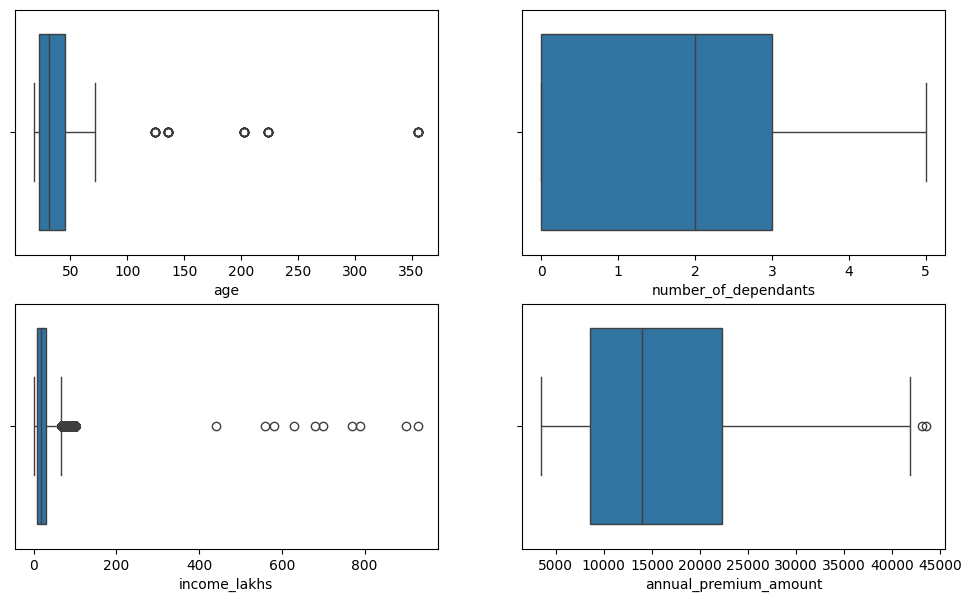

In [187]:
figure, axis=plt.subplots(num_rows, 2, figsize=(12,3.5*num_rows))
axis=axis.flatten()
for i, col in enumerate(numeric_columns):
    sns.boxplot(x=df[col], ax=axis[i])
plt.show()

### Outlier treatment: Age column

In [188]:
df.age.describe()

count    49976.000000
mean        34.591764
std         15.000378
min         18.000000
25%         22.000000
50%         31.000000
75%         45.000000
max        356.000000
Name: age, dtype: float64

In [189]:
df[df['age']>100].shape

(58, 13)

In [190]:
def limits(col):
    Q1=df[col].quantile(0.25)
    Q3=df[col].quantile(0.75)
    IQR=Q3-Q1
    lower_bound=Q1-1.5*IQR
    upper_bound=Q3+1.5*IQR
    return lower_bound, upper_bound

limits('age')

(np.float64(-12.5), np.float64(79.5))

In [191]:
df['age'].quantile(0.25)

np.float64(22.0)

In [192]:
df['age'].quantile(0.75)

np.float64(45.0)

In [193]:
df['age'].quantile(0.99)

np.float64(69.0)

In [194]:
df[df['age']>100].age.shape

(58,)

In [195]:
df1=df[df['age']<100].copy()
df1

,age,gender,region,marital_status,number_of_dependants,bmi_category,smoking_status,employment_status,income_level,income_lakhs,medical_history,insurance_plan,annual_premium_amount
0,26,Male,Northwest,Unmarried,0,Normal,No Smoking,Salaried,<10L,6,Diabetes,Bronze,9053
1,29,Female,Southeast,Married,2,Obesity,Regular,Salaried,<10L,6,Diabetes,Bronze,16339
2,49,Female,Northeast,Married,2,Normal,No Smoking,Self-Employed,10L - 25L,20,High blood pressure,Silver,18164
3,30,Female,Southeast,Married,3,Normal,No Smoking,Salaried,> 40L,77,No Disease,Gold,20303
4,18,Male,Northeast,Unmarried,0,Overweight,Regular,Self-Employed,> 40L,99,High blood pressure,Silver,13365
...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,24,Female,Northwest,Unmarried,0,Underweight,No Smoking,Self-Employed,25L - 40L,35,No Disease,Bronze,9111
49996,47,Female,Southeast,Married,2,Normal,No Smoking,Salaried,> 40L,82,Thyroid,Gold,27076
49997,21,Male,Northwest,Unmarried,0,Normal,Regular,Freelancer,25L - 40L,32,No Disease,Bronze,8564
49998,18,Male,Northwest,Unmarried,2,Normal,No Smoking,Salaried,10L - 25L,20,No Disease,Bronze,9490


In [196]:
df1.age.describe()

count    49918.000000
mean        34.401839
std         13.681600
min         18.000000
25%         22.000000
50%         31.000000
75%         45.000000
max         72.000000
Name: age, dtype: float64

### Outlier treatment :Income columns

In [197]:
def get_iqr_limits(col):
    Q1=df[col].quantile(0.25)
    Q3=df[col].quantile(0.75)
    IQR=Q3-Q1
    lower_bound=Q1-1.5*IQR
    upper_bound=Q3+1.5*IQR
    return lower_bound, upper_bound

get_iqr_limits('income_lakhs')

(np.float64(-29.0), np.float64(67.0))

In [198]:
df1[df1['income_lakhs']>67].shape

(3559, 13)

In [199]:
income_thershold=df1['income_lakhs'].quantile(0.999)
income_thershold

np.float64(100.0)

In [200]:
df2=df1[df1['income_lakhs']<=income_thershold].copy()
df2.shape

(49908, 13)

In [201]:
df2.head(2)

,age,gender,region,marital_status,number_of_dependants,bmi_category,smoking_status,employment_status,income_level,income_lakhs,medical_history,insurance_plan,annual_premium_amount
0,26,Male,Northwest,Unmarried,0,Normal,No Smoking,Salaried,<10L,6,Diabetes,Bronze,9053
1,29,Female,Southeast,Married,2,Obesity,Regular,Salaried,<10L,6,Diabetes,Bronze,16339


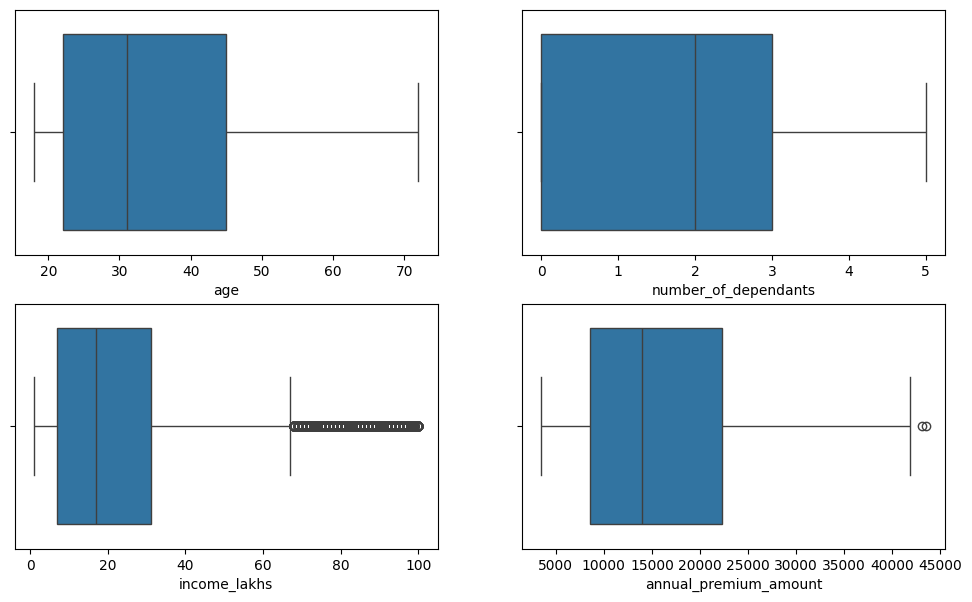

In [202]:
figure, axis=plt.subplots(num_rows, 2, figsize=(12,3.5*num_rows))
axis=axis.flatten()
for i, col in enumerate(numeric_columns):
    sns.boxplot(x=df2[col], ax=axis[i])
plt.show()

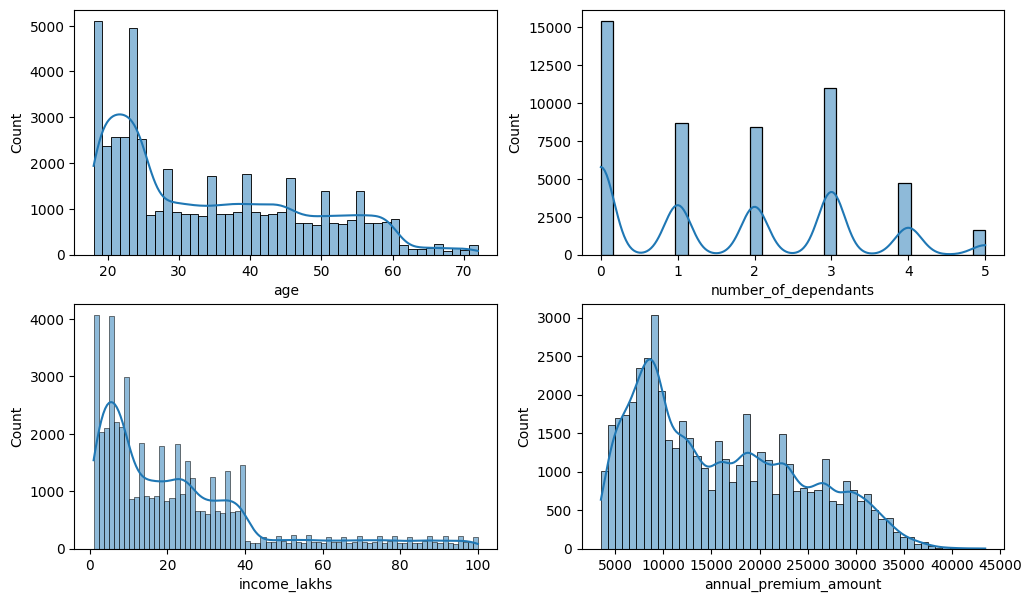

In [203]:
figure, axis=plt.subplots(num_rows, 2, figsize=(12,3.5*num_rows))
axis=axis.flatten()
for i, col in enumerate(numeric_columns):
    sns.histplot(x=df2[col], ax=axis[i], kde=True)
plt.show()

In [204]:
df2.describe()

,age,number_of_dependants,income_lakhs,annual_premium_amount
count,49908.000000,49908.000000,49908.000000,49908.000000
mean,34.401579,1.717640,22.889897,15765.739641
std,13.681604,1.492032,22.170699,8418.674061
min,18.000000,0.000000,1.000000,3501.000000
25%,22.000000,0.000000,7.000000,8608.000000
50%,31.000000,2.000000,17.000000,13928.000000
75%,45.000000,3.000000,31.000000,22270.500000
max,72.000000,5.000000,100.000000,43471.000000


### Bivariate Analysis:Numeric Columns

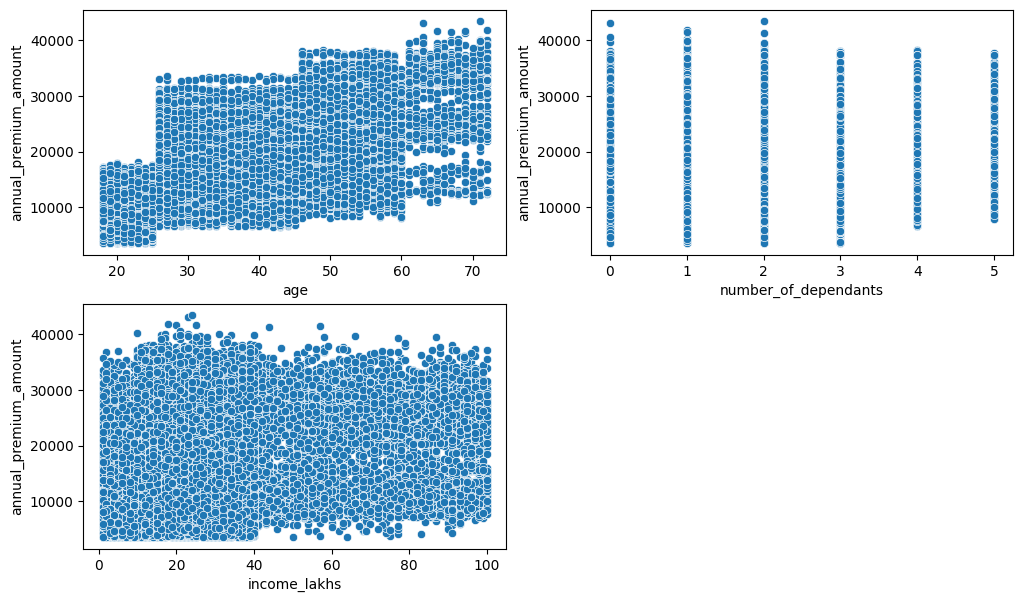

In [205]:
figure, axis=plt.subplots(num_rows, 2, figsize=(12,3.5*num_rows))
axis=axis.flatten()
for i, col in enumerate(numeric_columns):
    sns.scatterplot(x=df2[col], y=df2['annual_premium_amount'], ax=axis[i])


for i in range(len(numeric_columns)-1,len(numeric_columns)):
    figure.delaxes(axis[i])


plt.show()

## 2. Categorical Columns

In [206]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
Index: 49908 entries, 0 to 49999
Data columns (total 13 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   age                    49908 non-null  int64 
 1   gender                 49908 non-null  object
 2   region                 49908 non-null  object
 3   marital_status         49908 non-null  object
 4   number_of_dependants   49908 non-null  int64 
 5   bmi_category           49908 non-null  object
 6   smoking_status         49908 non-null  object
 7   employment_status      49908 non-null  object
 8   income_level           49908 non-null  object
 9   income_lakhs           49908 non-null  int64 
 10  medical_history        49908 non-null  object
 11  insurance_plan         49908 non-null  object
 12  annual_premium_amount  49908 non-null  int64 
dtypes: int64(4), object(9)
memory usage: 5.3+ MB


In [207]:
categorical_cols=df2.select_dtypes(include=['object']).columns
categorical_cols

Index(['gender', 'region', 'marital_status', 'bmi_category', 'smoking_status',
       'employment_status', 'income_level', 'medical_history',
       'insurance_plan'],
      dtype='object')

In [208]:
for col in categorical_cols:
    print(f" {col}--->{df2[col].unique()}")
    print("-"*50)

 gender--->['Male' 'Female']
--------------------------------------------------
 region--->['Northwest' 'Southeast' 'Northeast' 'Southwest']
--------------------------------------------------
 marital_status--->['Unmarried' 'Married']
--------------------------------------------------
 bmi_category--->['Normal' 'Obesity' 'Overweight' 'Underweight']
--------------------------------------------------
 smoking_status--->['No Smoking' 'Regular' 'Occasional' 'Smoking=0' 'Does Not Smoke'
 'Not Smoking']
--------------------------------------------------
 employment_status--->['Salaried' 'Self-Employed' 'Freelancer']
--------------------------------------------------
 income_level--->['<10L' '10L - 25L' '> 40L' '25L - 40L']
--------------------------------------------------
 medical_history--->['Diabetes' 'High blood pressure' 'No Disease'
 'Diabetes & High blood pressure' 'Thyroid' 'Heart disease'
 'High blood pressure & Heart disease' 'Diabetes & Thyroid'
 'Diabetes & Heart disease']
------

In [209]:
df2['smoking_status']=df2['smoking_status'].replace({'Smoking=0':'No Smoking',
                                                     'Does Not Smoke':'No Smoking',
                                                     'Not Smoking':'No Smoking'})

In [210]:
df2['smoking_status'].unique()

array(['No Smoking', 'Regular', 'Occasional'], dtype=object)

### Univariate Analysis

In [211]:
df2.head(2)

,age,gender,region,marital_status,number_of_dependants,bmi_category,smoking_status,employment_status,income_level,income_lakhs,medical_history,insurance_plan,annual_premium_amount
0,26,Male,Northwest,Unmarried,0,Normal,No Smoking,Salaried,<10L,6,Diabetes,Bronze,9053
1,29,Female,Southeast,Married,2,Obesity,Regular,Salaried,<10L,6,Diabetes,Bronze,16339


In [212]:
pct_count=df2.gender.value_counts(normalize=True)*100
pct_count

gender
Male      54.963132
Female    45.036868
Name: proportion, dtype: float64

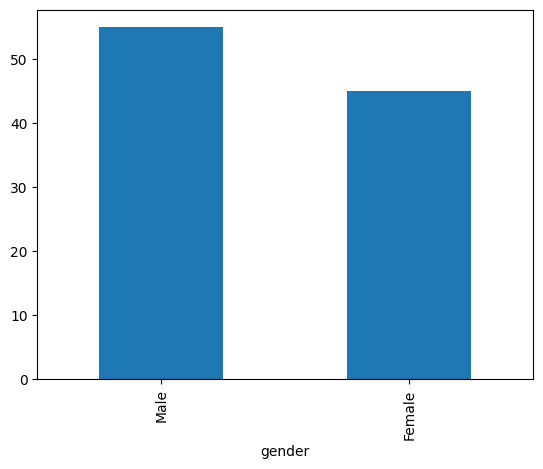

In [213]:
pct_count.plot(kind='bar')
plt.show()

In [214]:
num_rows_1=int(len(categorical_cols)/3)
num_rows_1

3

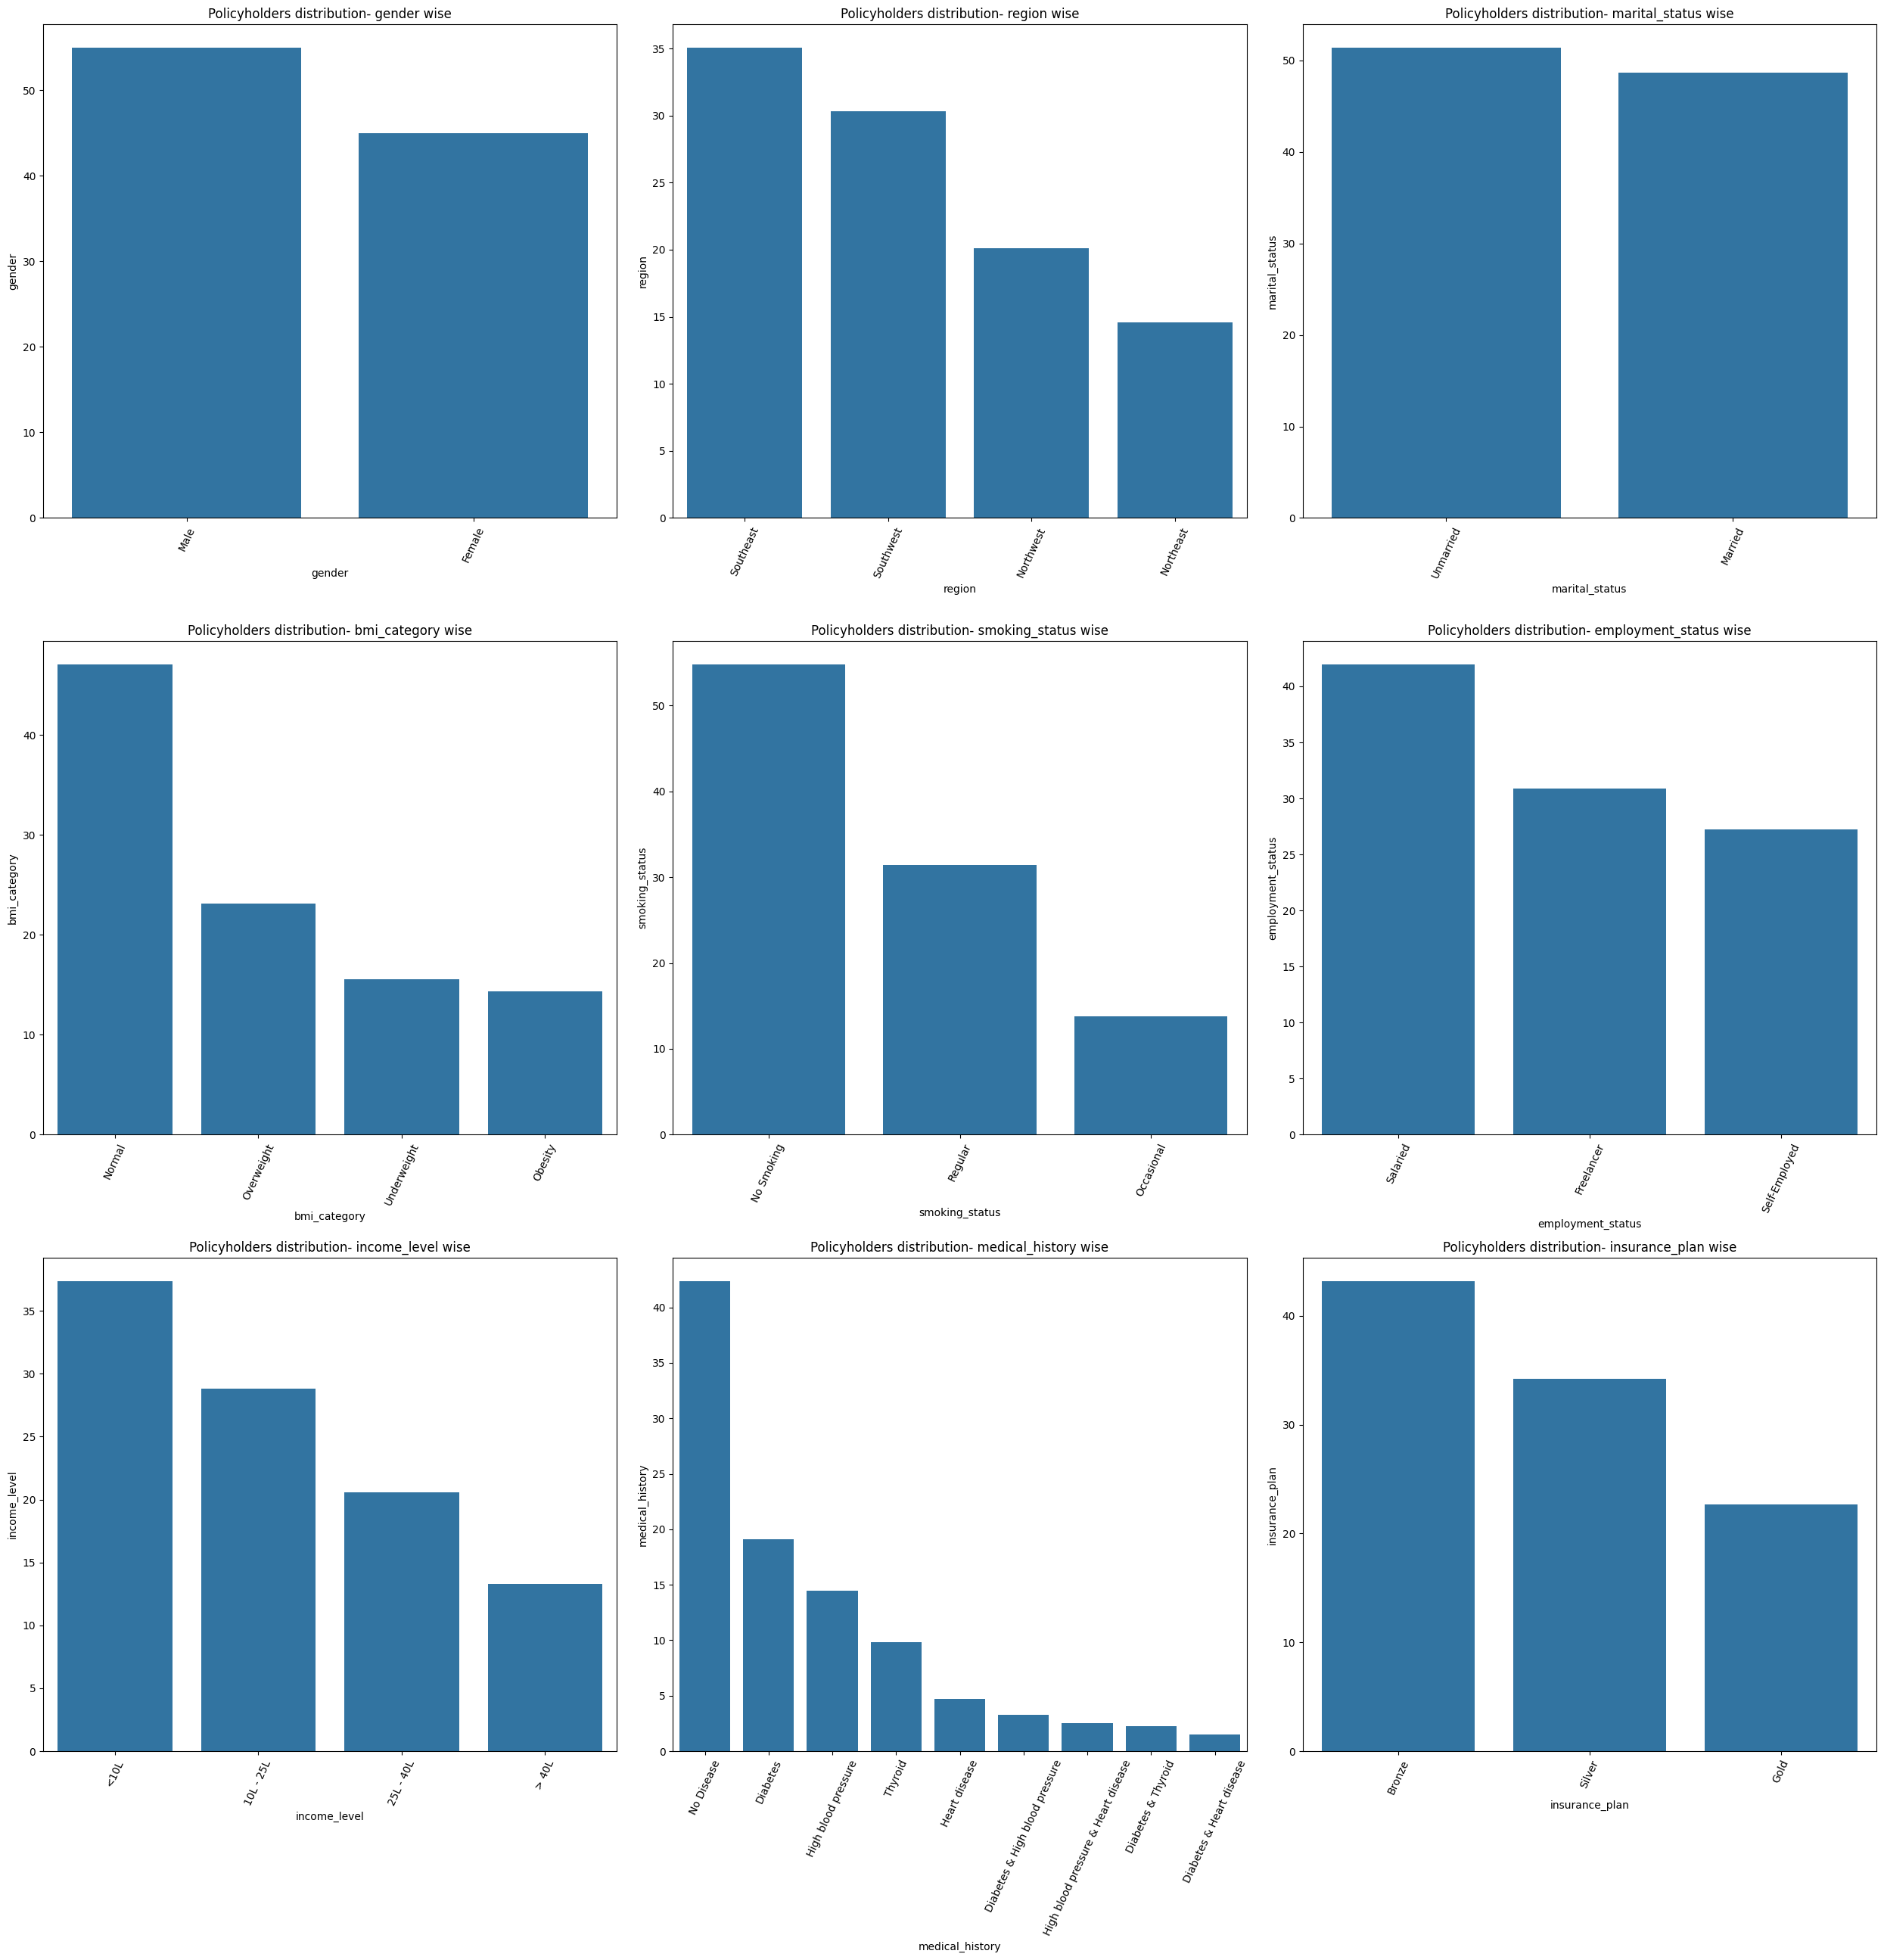

In [215]:
figure, axis=plt.subplots(num_rows_1, 3, figsize=(25, num_rows*13))
axis=axis.flatten()

for i, col in enumerate(categorical_cols):
    pct_count=df2[col].value_counts(normalize=True)*100
    sns.barplot(x=pct_count.index, y=pct_count.values, ax=axis[i])
    axis[i].set_title(f"Policyholders distribution- {col} wise")
    axis[i].set_ylabel(col)
    axis[i].tick_params(axis='x', rotation=65)
plt.tight_layout()
plt.show()

###  Bivariate Analysis

In [216]:
df2.head(2)

,age,gender,region,marital_status,number_of_dependants,bmi_category,smoking_status,employment_status,income_level,income_lakhs,medical_history,insurance_plan,annual_premium_amount
0,26,Male,Northwest,Unmarried,0,Normal,No Smoking,Salaried,<10L,6,Diabetes,Bronze,9053
1,29,Female,Southeast,Married,2,Obesity,Regular,Salaried,<10L,6,Diabetes,Bronze,16339


In [217]:
df3=df2.groupby(['income_level', 'insurance_plan'])[['insurance_plan']].count()
df3

insurance_plan
income_level insurance_plan                
10L - 25L    Bronze                    5307
             Gold                      3880
             Silver                    5182
25L - 40L    Bronze                    3683
             Gold                      2840
             Silver                    3750
<10L         Bronze                   12226
             Gold                       931
             Silver                    5486
> 40L        Bronze                     329
             Gold                      3653
             Silver                    2641

<Axes: xlabel='income_level', ylabel='insurance_plan'>

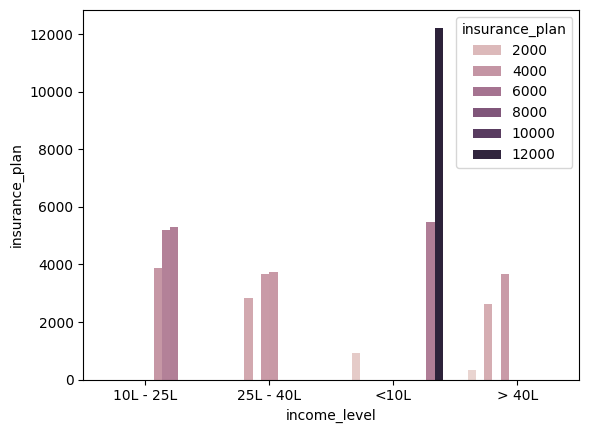

In [218]:
sns.barplot(data=df3, x='income_level', y='insurance_plan', hue='insurance_plan')

In [219]:
cross_tab=pd.crosstab(df2['income_level'], df2['insurance_plan'])
cross_tab

insurance_plan,Bronze,Gold,Silver
income_level,,,
10L - 25L,5307,3880,5182
25L - 40L,3683,2840,3750
<10L,12226,931,5486
> 40L,329,3653,2641


<Axes: xlabel='income_level'>

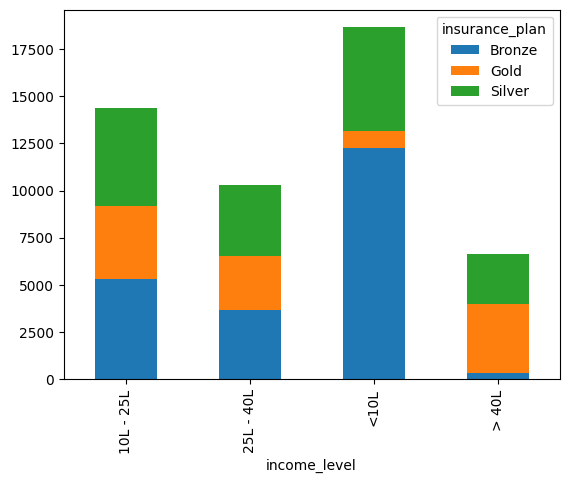

In [220]:
cross_tab.plot(kind='bar', stacked=True)

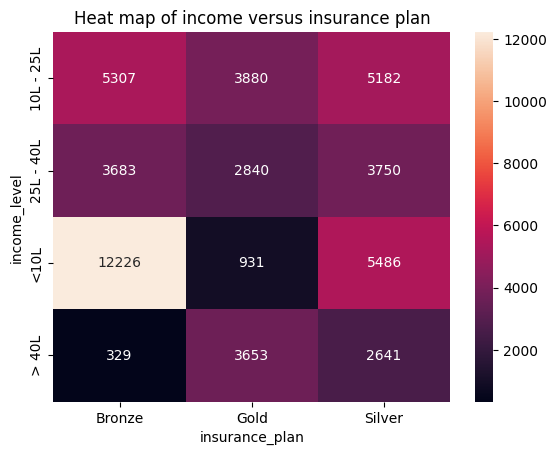

In [221]:
sns.heatmap(data=cross_tab, annot=True, fmt='d')
plt.title("Heat map of income versus insurance plan")
plt.show()

##  Feature Engineering

###  Calculate Risk Score

In [222]:
df2.head(2)

,age,gender,region,marital_status,number_of_dependants,bmi_category,smoking_status,employment_status,income_level,income_lakhs,medical_history,insurance_plan,annual_premium_amount
0,26,Male,Northwest,Unmarried,0,Normal,No Smoking,Salaried,<10L,6,Diabetes,Bronze,9053
1,29,Female,Southeast,Married,2,Obesity,Regular,Salaried,<10L,6,Diabetes,Bronze,16339


In [223]:
df2.medical_history.unique()

array(['Diabetes', 'High blood pressure', 'No Disease',
       'Diabetes & High blood pressure', 'Thyroid', 'Heart disease',
       'High blood pressure & Heart disease', 'Diabetes & Thyroid',
       'Diabetes & Heart disease'], dtype=object)

In [224]:
#define risk score for each condition
risk_score={"diabetes":6, "heart disease":8, "high blood pressure":6, "thyroid" :5, "no Disease":0, 'none':0}
df2[["disease_1","disease_2"]]=df2['medical_history'].str.split(" & ", expand=True).apply(lambda x:x.str.lower())
df2['disease_1']=df2['disease_1'].fillna('none')
df2['disease_2']=df2['disease_2'].fillna('none')

df2['total_risk_score']=0
for disease in ['disease_1', 'disease_2']:
    df2[disease]=df2[disease].map(risk_score)
    df2['total_risk_score']+=df2[disease]

In [225]:
df2['total_risk_score']=df2['total_risk_score'].fillna(0)

In [226]:
#normalization of risk score

from sklearn.preprocessing import MinMaxScaler
scaler=MinMaxScaler()
df2['normalized_risk_score']=scaler.fit_transform(df2[['total_risk_score']])
df2.head(4)

,age,gender,region,marital_status,number_of_dependants,bmi_category,smoking_status,employment_status,income_level,income_lakhs,medical_history,insurance_plan,annual_premium_amount,disease_1,disease_2,total_risk_score,normalized_risk_score
0,26,Male,Northwest,Unmarried,0,Normal,No Smoking,Salaried,<10L,6,Diabetes,Bronze,9053,6.0,0,6.0,0.428571
1,29,Female,Southeast,Married,2,Obesity,Regular,Salaried,<10L,6,Diabetes,Bronze,16339,6.0,0,6.0,0.428571
2,49,Female,Northeast,Married,2,Normal,No Smoking,Self-Employed,10L - 25L,20,High blood pressure,Silver,18164,6.0,0,6.0,0.428571
3,30,Female,Southeast,Married,3,Normal,No Smoking,Salaried,> 40L,77,No Disease,Gold,20303,NaN,0,0.0,0.000000


### Encode Text column

In [227]:
df2['insurance_plan']=df2['insurance_plan'].map({'Bronze':1, 'Silver':2,'Gold':3})

In [228]:
df2.insurance_plan.unique()

array([1, 2, 3])

In [229]:
df2.income_level.unique()

array(['<10L', '10L - 25L', '> 40L', '25L - 40L'], dtype=object)

In [230]:
df2['income_level']=df2['income_level'].map({'<10L':1, '10L - 25L':2, '> 40L':3, '25L - 40L':4})

In [231]:
df2.columns

Index(['age', 'gender', 'region', 'marital_status', 'number_of_dependants',
       'bmi_category', 'smoking_status', 'employment_status', 'income_level',
       'income_lakhs', 'medical_history', 'insurance_plan',
       'annual_premium_amount', 'disease_1', 'disease_2', 'total_risk_score',
       'normalized_risk_score'],
      dtype='object')

In [232]:
nominal_cols=['gender','region','marital_status','bmi_category','smoking_status','employment_status']

df3=pd.get_dummies(df2, columns=nominal_cols, drop_first=True, dtype=int)

In [233]:
df3.head(4)

,age,number_of_dependants,income_level,income_lakhs,medical_history,insurance_plan,annual_premium_amount,disease_1,disease_2,total_risk_score,...,region_Southeast,region_Southwest,marital_status_Unmarried,bmi_category_Obesity,bmi_category_Overweight,bmi_category_Underweight,smoking_status_Occasional,smoking_status_Regular,employment_status_Salaried,employment_status_Self-Employed
0,26,0,1,6,Diabetes,1,9053,6.0,0,6.0,...,0,0,1,0,0,0,0,0,1,0
1,29,2,1,6,Diabetes,1,16339,6.0,0,6.0,...,1,0,0,1,0,0,0,1,1,0
2,49,2,2,20,High blood pressure,2,18164,6.0,0,6.0,...,0,0,0,0,0,0,0,0,0,1
3,30,3,3,77,No Disease,3,20303,NaN,0,0.0,...,1,0,0,0,0,0,0,0,1,0


In [234]:
df3.info()

<class 'pandas.core.frame.DataFrame'>
Index: 49908 entries, 0 to 49999
Data columns (total 23 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   age                              49908 non-null  int64  
 1   number_of_dependants             49908 non-null  int64  
 2   income_level                     49908 non-null  int64  
 3   income_lakhs                     49908 non-null  int64  
 4   medical_history                  49908 non-null  object 
 5   insurance_plan                   49908 non-null  int64  
 6   annual_premium_amount            49908 non-null  int64  
 7   disease_1                        28770 non-null  float64
 8   disease_2                        49908 non-null  int64  
 9   total_risk_score                 49908 non-null  float64
 10  normalized_risk_score            49908 non-null  float64
 11  gender_Male                      49908 non-null  int64  
 12  region_Northwest       

### Feature Selection

In [235]:
dropped_columns=['medical_history', 'total_risk_score', 'disease_1', 'disease_2']
df4=df3.drop(dropped_columns, axis=1)

In [236]:
df4

,age,number_of_dependants,income_level,income_lakhs,insurance_plan,annual_premium_amount,normalized_risk_score,gender_Male,region_Northwest,region_Southeast,region_Southwest,marital_status_Unmarried,bmi_category_Obesity,bmi_category_Overweight,bmi_category_Underweight,smoking_status_Occasional,smoking_status_Regular,employment_status_Salaried,employment_status_Self-Employed
0,26,0,1,6,1,9053,0.428571,1,1,0,0,1,0,0,0,0,0,1,0
1,29,2,1,6,1,16339,0.428571,0,0,1,0,0,1,0,0,0,1,1,0
2,49,2,2,20,2,18164,0.428571,0,0,0,0,0,0,0,0,0,0,0,1
3,30,3,3,77,3,20303,0.000000,0,0,1,0,0,0,0,0,0,0,1,0
4,18,0,3,99,2,13365,0.428571,1,0,0,0,1,0,1,0,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,24,0,4,35,1,9111,0.000000,0,1,0,0,1,0,0,1,0,0,0,1
49996,47,2,3,82,3,27076,0.357143,0,0,1,0,0,0,0,0,0,0,1,0
49997,21,0,4,32,1,8564,0.000000,1,1,0,0,1,0,0,0,0,1,0,0
49998,18,2,2,20,1,9490,0.000000,1,1,0,0,1,0,0,0,0,0,1,0


### Calculate VIF for multicolinearity

In [237]:
df4.columns

Index(['age', 'number_of_dependants', 'income_level', 'income_lakhs',
       'insurance_plan', 'annual_premium_amount', 'normalized_risk_score',
       'gender_Male', 'region_Northwest', 'region_Southeast',
       'region_Southwest', 'marital_status_Unmarried', 'bmi_category_Obesity',
       'bmi_category_Overweight', 'bmi_category_Underweight',
       'smoking_status_Occasional', 'smoking_status_Regular',
       'employment_status_Salaried', 'employment_status_Self-Employed'],
      dtype='object')

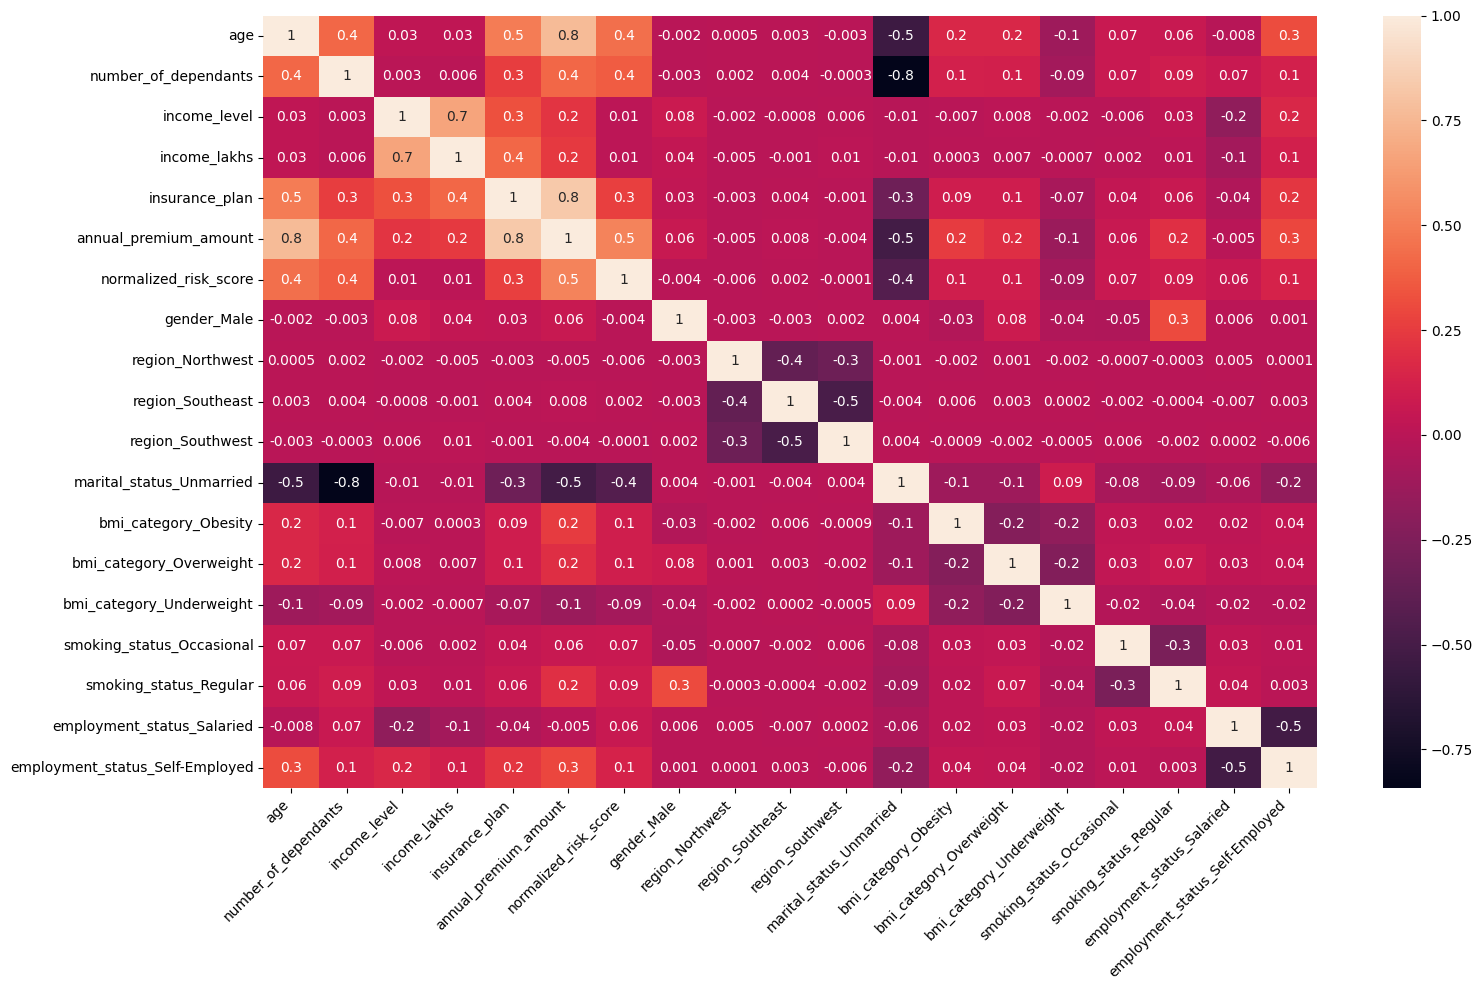

In [238]:
cm=df4.corr()

plt.figure(figsize=(16,10))
sns.heatmap(cm, annot=True, fmt='0.1g')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

In [239]:
X=df4.drop('annual_premium_amount', axis=1)
y=df4['annual_premium_amount']
scaler=MinMaxScaler()
cols=['age', 'number_of_dependants', 'income_level', 'income_lakhs', 'insurance_plan']
X[cols]=scaler.fit_transform(X[cols])

X.describe()

,age,number_of_dependants,income_level,income_lakhs,insurance_plan,normalized_risk_score,gender_Male,region_Northwest,region_Southeast,region_Southwest,marital_status_Unmarried,bmi_category_Obesity,bmi_category_Overweight,bmi_category_Underweight,smoking_status_Occasional,smoking_status_Regular,employment_status_Salaried,employment_status_Self-Employed
count,49908.000000,49908.000000,49908.000000,49908.000000,49908.000000,49908.000000,49908.000000,49908.00000,49908.000000,49908.000000,49908.000000,49908.000000,49908.000000,49908.000000,49908.000000,49908.000000,49908.000000,49908.000000
mean,0.303733,0.343528,0.390278,0.221110,0.397401,0.291831,0.549631,0.20093,0.350385,0.303038,0.513545,0.143183,0.231245,0.155326,0.138274,0.313857,0.419412,0.272041
std,0.253363,0.298406,0.380124,0.223946,0.392459,0.287420,0.497536,0.40070,0.477095,0.459576,0.499822,0.350263,0.421633,0.362219,0.345191,0.464064,0.493468,0.445015
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.074074,0.000000,0.000000,0.060606,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.240741,0.400000,0.333333,0.161616,0.500000,0.357143,1.000000,0.00000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.500000,0.600000,0.666667,0.303030,0.500000,0.428571,1.000000,0.00000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [240]:
def calculate_vif(data):
    vif_df=pd.DataFrame()
    vif_df['variable']=data.columns
    vif_df['VIF']=[variance_inflation_factor(data.values,i) for i in range (data.shape[1])]
    return vif_df

In [241]:
calculate_vif(X)

,variable,VIF
0,age,4.546828
1,number_of_dependants,4.552788
2,income_level,3.809392
3,income_lakhs,3.940341
4,insurance_plan,3.470028
5,normalized_risk_score,2.688740
6,gender_Male,2.424683
7,region_Northwest,2.103537
8,region_Southeast,2.923930
9,region_Southwest,2.671921


In [242]:
calculate_vif(X.drop('income_level', axis=1))

,variable,VIF
0,age,4.545825
1,number_of_dependants,4.526598
2,income_lakhs,2.480563
3,insurance_plan,3.445682
4,normalized_risk_score,2.687326
5,gender_Male,2.409980
6,region_Northwest,2.100789
7,region_Southeast,2.919775
8,region_Southwest,2.668314
9,marital_status_Unmarried,3.393718


In [243]:
X_reduced=X.drop('income_level', axis=1)

##  Model Training

In [244]:
X_train, X_test, y_train, y_test=train_test_split(X_reduced, y, test_size=0.3, random_state=42)

#print shape of X_reduced, X_train, X_test, y_train, y_test features
print(f"X_reduced shape: {X_reduced.shape}")
print(f"X_train shape: {X_train.shape}")
print(f"X_test shape : {X_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")

X_reduced shape: (49908, 17)
X_train shape: (34935, 17)
X_test shape : (14973, 17)
y_train shape: (34935,)
y_test shape: (14973,)


### Linear Regression model

In [245]:
model_lr=LinearRegression()
#training a model
model_lr.fit(X_train, y_train)

#predicting model r2 score
test_score=model_lr.score(X_test, y_test)
train_score=model_lr.score(X_train, y_train)
test_score, train_score

(0.9283765993531427, 0.9280957176093705)

In [246]:
#prediction values
y_pred=model_lr.predict(X_test)

#RMSE 
mse=mean_squared_error(y_test, y_pred)
rmse=np.sqrt(mse)
print(f"Linear Regression MSE {mse}, RMSE: {rmse}")

Linear Regression MSE 5056639.130347776, RMSE: 2248.6972073509087


In [247]:
len(model_lr.coef_)

17

In [248]:
len(X_train.columns)

17

In [249]:
feature_importance=model_lr.coef_
feature_importance

array([11236.4082633 ,  -536.61172956,  -353.97067084, 12515.43782972,
        4846.88626348,   121.53023031,   -34.50219135,    27.97504587,
         -23.47372614,  -821.78088646,  3356.07750448,  1613.1421694 ,
         364.31350886,   722.41051531,  2261.97816483,   149.57179545,
         378.25130285])

In [250]:
coef_df=pd.DataFrame(feature_importance,index=X_train.columns, columns=['Coefficient'])
coef_df=coef_df.sort_values(by='Coefficient')

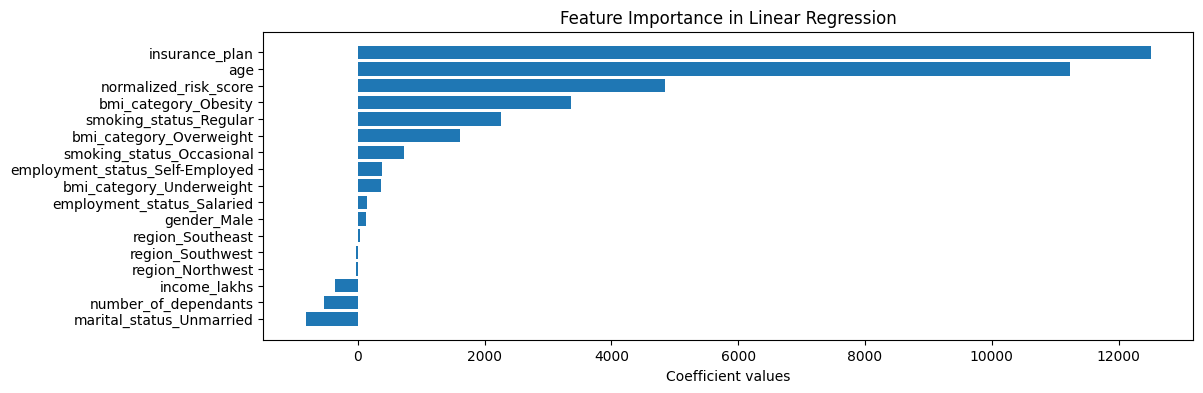

In [251]:
plt.figure(figsize=(12,4))
plt.barh(data=coef_df, y=coef_df.index,width=coef_df.Coefficient)
plt.xlabel('Coefficient values')
plt.title('Feature Importance in Linear Regression')
plt.show()

### Ridge Regression model

In [252]:
model_rg=Ridge(alpha=1)
model_rg.fit(X_train, y_train)

Ridge(alpha=1)

In [253]:
test_score_rg=model_rg.score(X_test, y_test)
train_score_rg=model_rg.score(X_train, y_train)
train_score, test_score

(0.9280957176093705, 0.9283765993531427)

In [254]:
y_pred_rg=model_rg.predict(X_test)
MSE_rg=mean_squared_error(y_test,y_pred_rg)
RMSE_rg=np.sqrt(MSE_rg)
R2_score_rg=r2_score(y_test,y_pred_rg)

print(f"RMSE of Ridge regression model {RMSE_rg}, R2 Score of Ridge regression {R2_score_rg}")

RMSE of Ridge regression model 2248.698916130618, R2 Score of Ridge regression 0.9283764905001946


### XGBoost

In [255]:
model_xgb=XGBRegressor(n_estimators=100)
model_xgb.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=100,
             n_jobs=None, num_parallel_tree=None, ...)

In [256]:
y_pred_xgb=model_xgb.predict(X_test)

In [257]:
test_score_xgb=model_xgb.score(X_test, y_test)
train_score_xgb=model_xgb.score(X_train, y_train)
train_score, test_score

(0.9280957176093705, 0.9283765993531427)

In [258]:
y_pred_xgb=model_xgb.predict(X_test)
MSE_xgb=mean_squared_error(y_test,y_pred_xgb)
RMSE_xgb=np.sqrt(MSE_xgb)
R2_score_xgb=r2_score(y_test,y_pred_xgb)

print(f"RMSE of Ridge regression model {RMSE_xgb}, R2 Score of Ridge regression {R2_score_xgb}")

RMSE of Ridge regression model 1165.1131919260033, R2 Score of Ridge regression 0.9807721972465515


#### Randomized SearchCV

In [259]:
model_xgb=XGBRegressor()
param_grid={
            'n_estimators':[20,40,50],
            'learning_rate':[0.01,0.1,0.2],
            'max_depth':[3,4,5] }
random_search=RandomizedSearchCV(model_xgb, param_grid,n_iter=10, cv=3, scoring='r2',random_state=42, n_jobs=-1)
random_search

RandomizedSearchCV(cv=3,
                   estimator=XGBRegressor(base_score=None, booster=None,
                                          callbacks=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None, device=None,
                                          early_stopping_rounds=None,
                                          enable_categorical=False,
                                          eval_metric=None, feature_types=None,
                                          feature_weights=None, gamma=None,
                                          grow_policy=None,
                                          importance_type=None,
                                          interaction_constraint...
                                          max_cat_to_onehot=None,
                                          max_delta_step=None, max_depth=None,
                                          max_leaves=None,
                                          min_child_weight=None, missing=nan,
                                          monotone_constraints=None,
                                          multi_strategy=None,
                                          n_estimators=None, n_jobs=None,
                                          num_parallel_tree=None, ...),
                   n_jobs=-1,
                   param_distributions={'learning_rate': [0.01, 0.1, 0.2],
                                        'max_depth': [3, 4, 5],
                                        'n_estimators': [20, 40, 50]},
                   random_state=42, scoring='r2')

In [260]:
random_search.fit(X_train, y_train)

RandomizedSearchCV(cv=3,
                   estimator=XGBRegressor(base_score=None, booster=None,
                                          callbacks=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None, device=None,
                                          early_stopping_rounds=None,
                                          enable_categorical=False,
                                          eval_metric=None, feature_types=None,
                                          feature_weights=None, gamma=None,
                                          grow_policy=None,
                                          importance_type=None,
                                          interaction_constraint...
                                          max_cat_to_onehot=None,
                                          max_delta_step=None, max_depth=None,
                                          max_leaves=None,
                                          min_child_weight=None, missing=nan,
                                          monotone_constraints=None,
                                          multi_strategy=None,
                                          n_estimators=None, n_jobs=None,
                                          num_parallel_tree=None, ...),
                   n_jobs=-1,
                   param_distributions={'learning_rate': [0.01, 0.1, 0.2],
                                        'max_depth': [3, 4, 5],
                                        'n_estimators': [20, 40, 50]},
                   random_state=42, scoring='r2')

In [261]:
random_search.best_score_

np.float64(0.9810737768809)

In [262]:
random_search.best_params_

{'n_estimators': 50, 'max_depth': 5, 'learning_rate': 0.1}

In [263]:
best_model=random_search.best_estimator_
best_model

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.1, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=5,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=50,
             n_jobs=None, num_parallel_tree=None, ...)

In [264]:
feature_importance=best_model.feature_importances_

#create DataFrame for Data Handling
coef_df=pd.DataFrame(feature_importance,index=X_train.columns, columns=['Coefficient'])
coef_df=coef_df.sort_values(by='Coefficient')

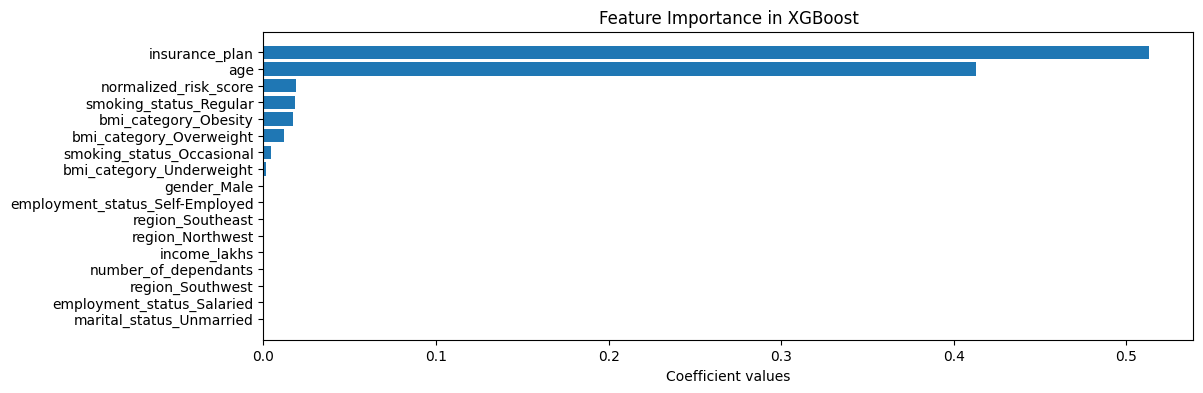

In [265]:
plt.figure(figsize=(12,4))
plt.barh(data=coef_df, y=coef_df.index,width=coef_df.Coefficient)
plt.xlabel('Coefficient values')
plt.title('Feature Importance in XGBoost')
plt.show()

Feature importance in XGBoost may not be as straightforward to interpret as feature importance in Linear Regression, Since XGBoost is a tree based model.

##  Error Analysis

In [266]:
y_pred=best_model.predict(X_test)
residuals=y_pred-y_test
residuals_pct=residuals*100/y_test
result_df=pd.DataFrame({'Truth':y_test, 'Prediction':y_pred, 'diff':residual, 'diff_pct':residual_pct})
result_df

,Truth,Prediction,diff,diff_pct
24098,9246,9547.453125,301.453125,3.260363
201,11664,13488.259766,1824.259766,15.640087
25471,10472,7417.219727,-3054.780273,-29.170935
32500,26267,25508.873047,-758.126953,-2.886233
30832,9106,9547.453125,441.453125,4.847937
...,...,...,...,...
12123,9529,9661.944336,132.944336,1.395155
31891,14240,15142.935547,902.935547,6.340840
6713,16992,16899.757812,-92.242188,-0.542857
16957,25620,25217.984375,-402.015625,-1.569148


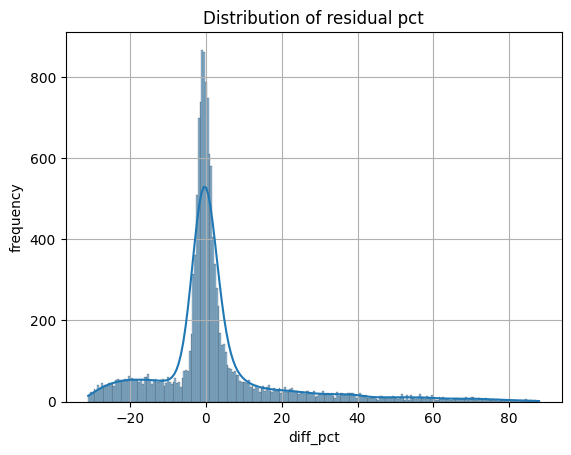

In [267]:
sns.histplot(result_df['diff_pct'], kde=True)
plt.grid()
plt.title('Distribution of residual pct')
plt.ylabel('frequency')
plt.show()

In [268]:
extreme_error_thresh=10
extreme_result_df=result_df[np.abs(result_df['diff_pct'])>=extreme_error_thresh]
extreme_result_df

,Truth,Prediction,diff,diff_pct
201,11664,13488.259766,1824.259766,15.640087
25471,10472,7417.219727,-3054.780273,-29.170935
47939,11996,13450.725586,1454.725586,12.126755
26239,4436,6649.229492,2213.229492,49.892459
16907,8952,10888.099609,1936.099609,21.627565
...,...,...,...,...
21893,9260,8086.385254,-1173.614746,-12.674025
37321,9087,6578.916016,-2508.083984,-27.600792
43822,4407,7308.467285,2901.467285,65.837697
24771,13239,14609.392578,1370.392578,10.351179


In [269]:
X_test.shape, y_test.shape, result_df.shape

((14973, 17), (14973,), (14973, 4))

In [270]:
(extreme_result_df.shape[0]/X_test.shape[0])*100

29.827021972884527

29.82% of data are having error greater than 10% which we around 30 % of customers are overcharged or undercharged by 10% or more.

In [271]:
extreme_error_thresh=50
extreme_result_df_50=result_df[np.abs(result_df['diff_pct'])>=extreme_error_thresh]
extreme_result_df_50

,Truth,Prediction,diff,diff_pct
32319,3731,6658.301270,2927.301270,78.458892
39035,4593,7027.422852,2434.422852,53.002892
31661,3902,6578.916016,2676.916016,68.603691
31322,3879,6784.298340,2905.298340,74.898127
36409,4225,7133.054688,2908.054688,68.829697
...,...,...,...,...
38440,4695,7424.533691,2729.533691,58.137033
7399,3964,6578.916016,2614.916016,65.966600
41789,4580,7117.171387,2537.171387,55.396755
10671,3791,6649.229492,2858.229492,75.395133


In [272]:
(extreme_result_df_50.shape[0]/X_test.shape[0])*100

3.5597408668937423

3.55% of data are having error greater than 50% which we around 3.5% of customers are overcharged or undercharged by 50% or more.

In [273]:
extreme_errors=X_test.loc[extreme_result_df.index]
extreme_errors

,age,number_of_dependants,income_lakhs,insurance_plan,normalized_risk_score,gender_Male,region_Northwest,region_Southeast,region_Southwest,marital_status_Unmarried,bmi_category_Obesity,bmi_category_Overweight,bmi_category_Underweight,smoking_status_Occasional,smoking_status_Regular,employment_status_Salaried,employment_status_Self-Employed
201,0.129630,0.2,0.636364,1.0,0.0,0,1,0,0,1,0,0,0,0,0,0,0
25471,0.074074,0.0,0.010101,0.0,0.0,1,1,0,0,1,0,1,0,0,1,1,0
47939,0.111111,0.0,0.424242,1.0,0.0,0,1,0,0,1,0,0,1,0,0,1,0
26239,0.037037,0.0,0.292929,0.0,0.0,1,1,0,0,1,0,0,1,0,0,0,0
16907,0.111111,0.0,0.606061,0.5,0.0,1,0,0,0,1,0,0,1,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21893,0.129630,0.4,0.242424,0.0,0.0,1,0,1,0,1,1,0,0,0,1,0,0
37321,0.018519,0.4,0.171717,0.0,0.0,0,0,1,0,0,0,0,0,0,0,1,0
43822,0.111111,0.2,0.020202,0.0,0.0,0,0,1,0,1,1,0,0,0,0,0,0
24771,0.425926,0.6,0.313131,0.5,0.0,0,0,1,0,0,0,0,0,0,0,0,0


In [274]:
df4.loc[extreme_result_df.index]


,age,number_of_dependants,income_level,income_lakhs,insurance_plan,annual_premium_amount,normalized_risk_score,gender_Male,region_Northwest,region_Southeast,region_Southwest,marital_status_Unmarried,bmi_category_Obesity,bmi_category_Overweight,bmi_category_Underweight,smoking_status_Occasional,smoking_status_Regular,employment_status_Salaried,employment_status_Self-Employed
201,25,1,3,64,3,11664,0.0,0,1,0,0,1,0,0,0,0,0,0,0
25471,22,0,1,2,1,10472,0.0,1,1,0,0,1,0,1,0,0,1,1,0
47939,24,0,3,43,3,11996,0.0,0,1,0,0,1,0,0,1,0,0,1,0
26239,20,0,4,30,1,4436,0.0,1,1,0,0,1,0,0,1,0,0,0,0
16907,24,0,3,61,2,8952,0.0,1,0,0,0,1,0,0,1,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21893,25,2,2,25,1,9260,0.0,1,0,1,0,1,1,0,0,0,1,0,0
37321,19,2,2,18,1,9087,0.0,0,0,1,0,0,0,0,0,0,0,1,0
43822,24,1,1,3,1,4407,0.0,0,0,1,0,1,1,0,0,0,0,0,0
24771,41,3,4,32,2,13239,0.0,0,0,1,0,0,0,0,0,0,0,0,0


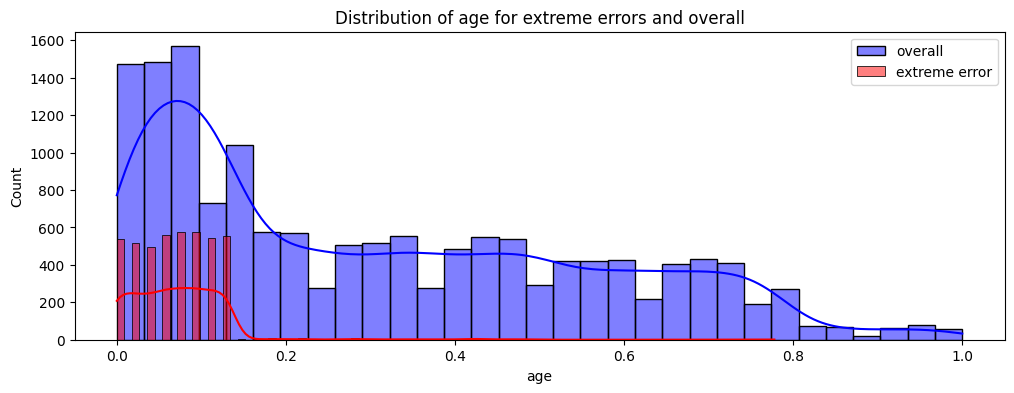

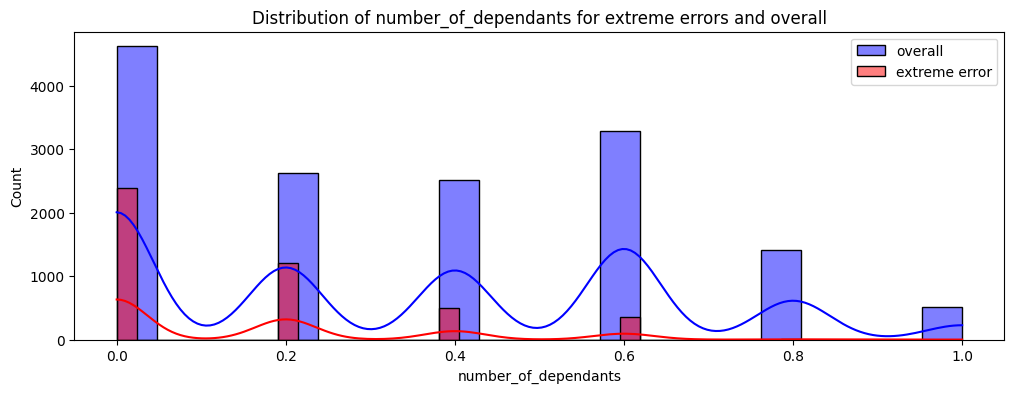

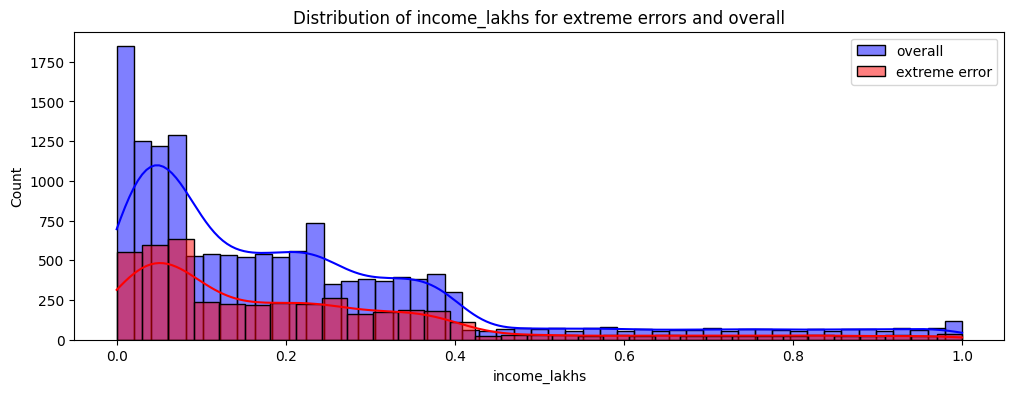

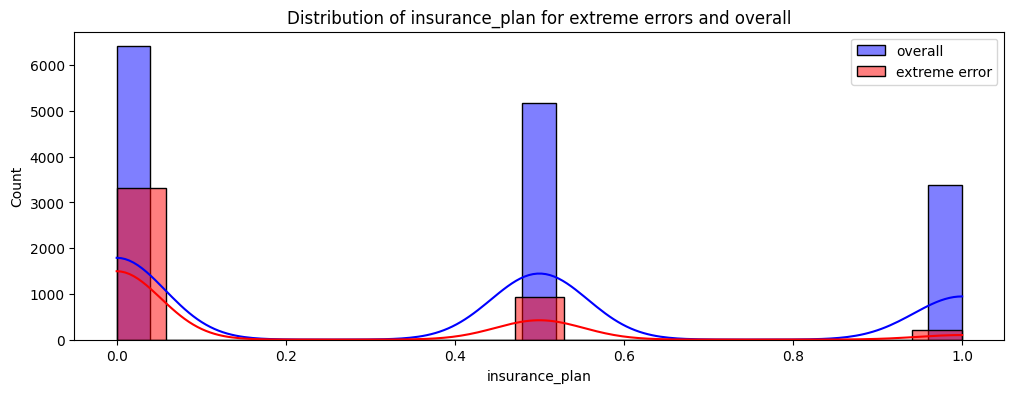

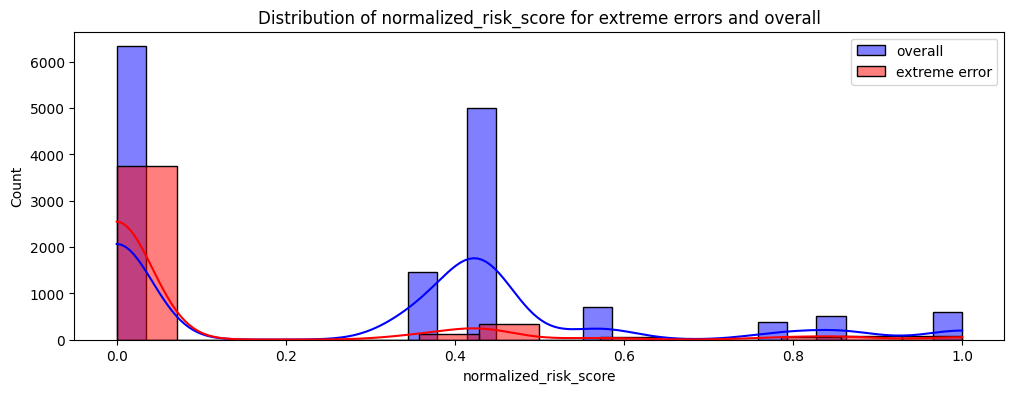

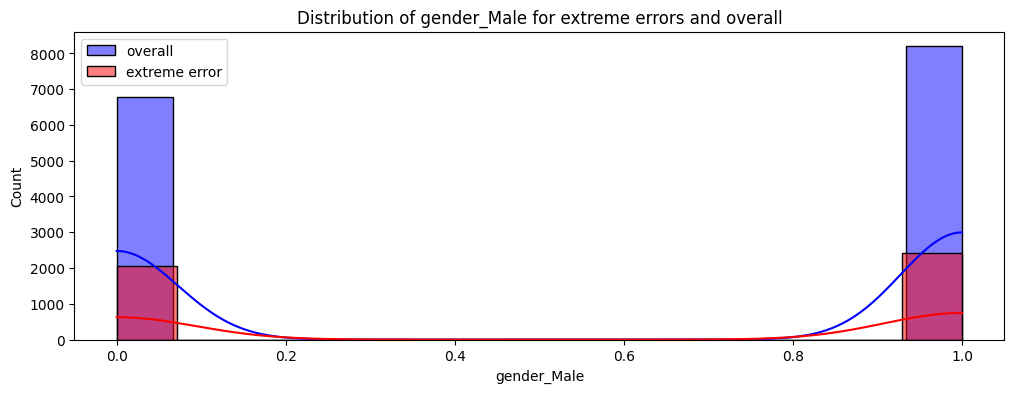

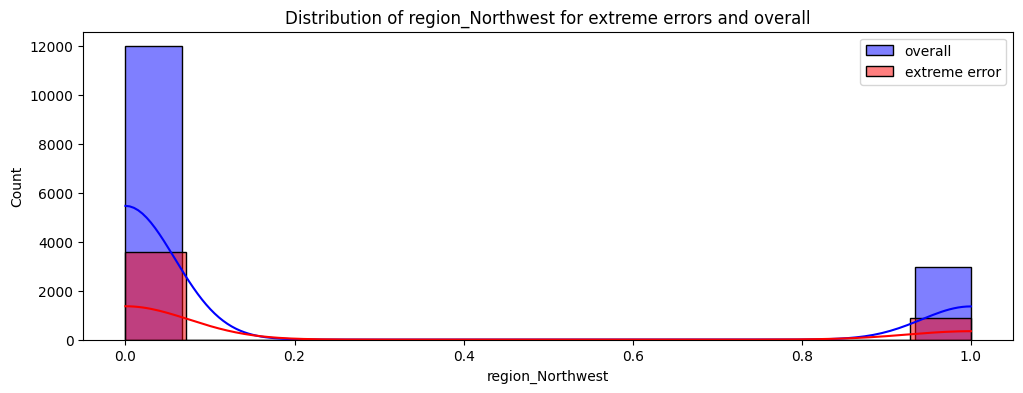

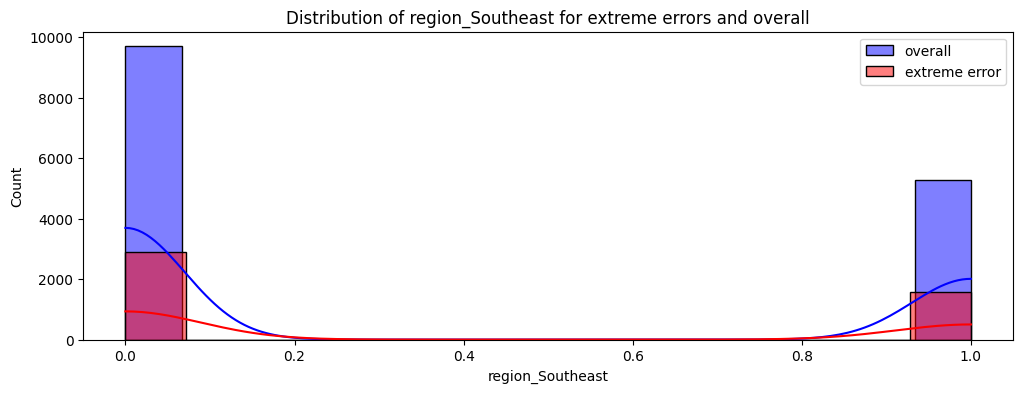

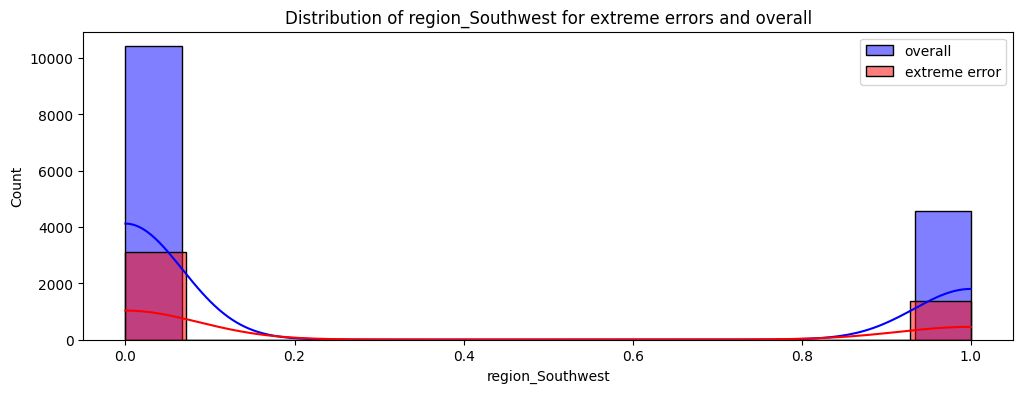

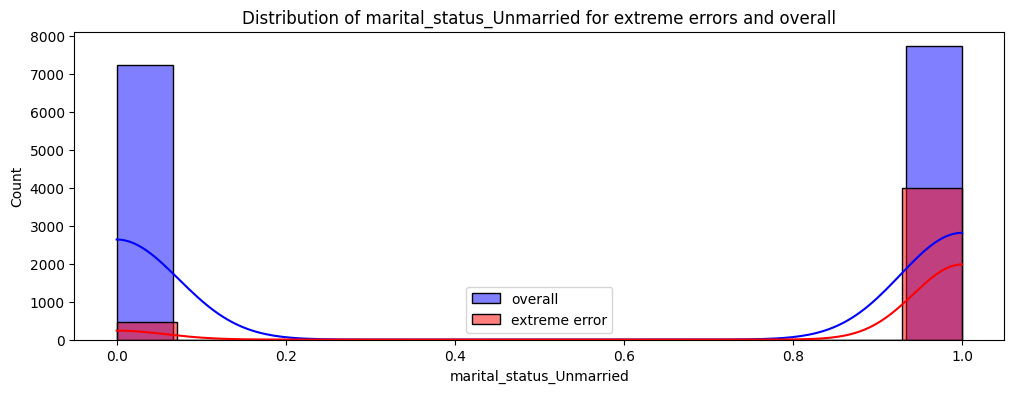

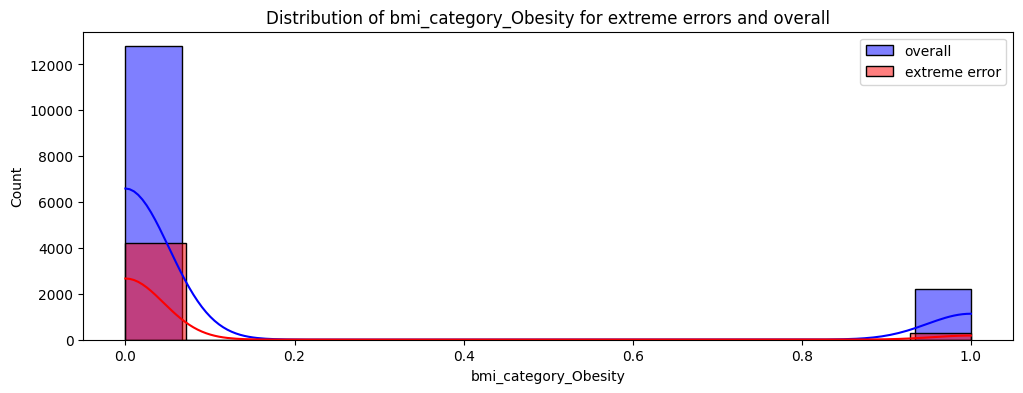

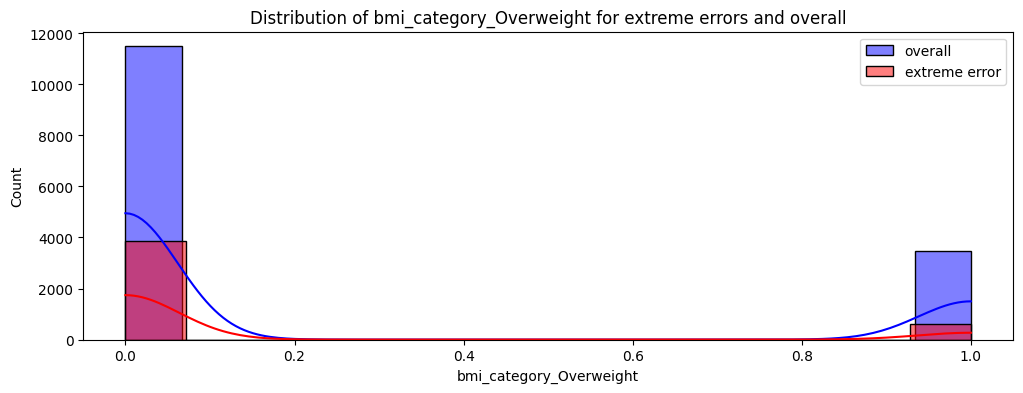

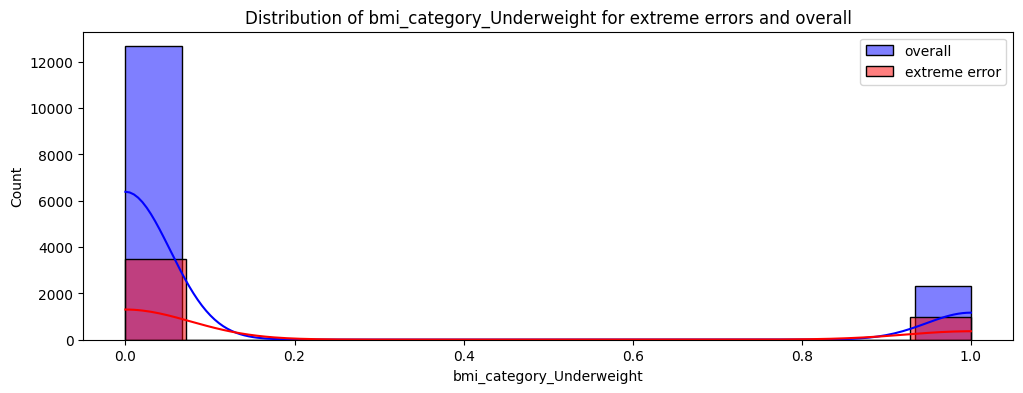

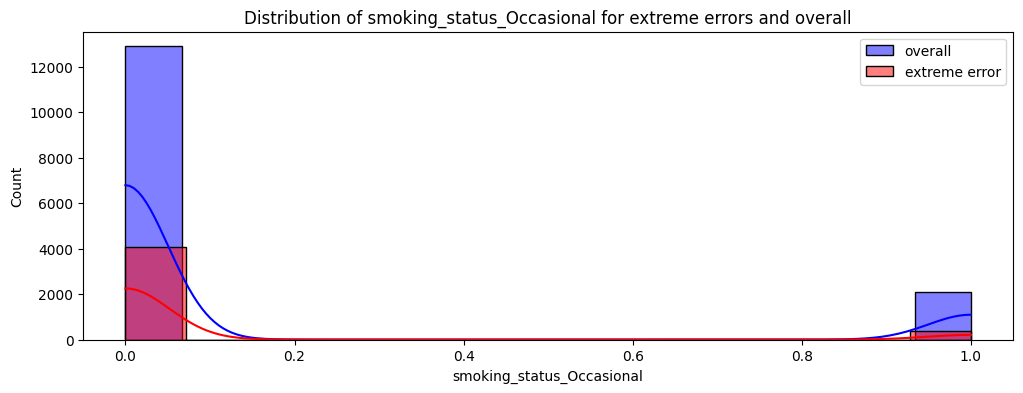

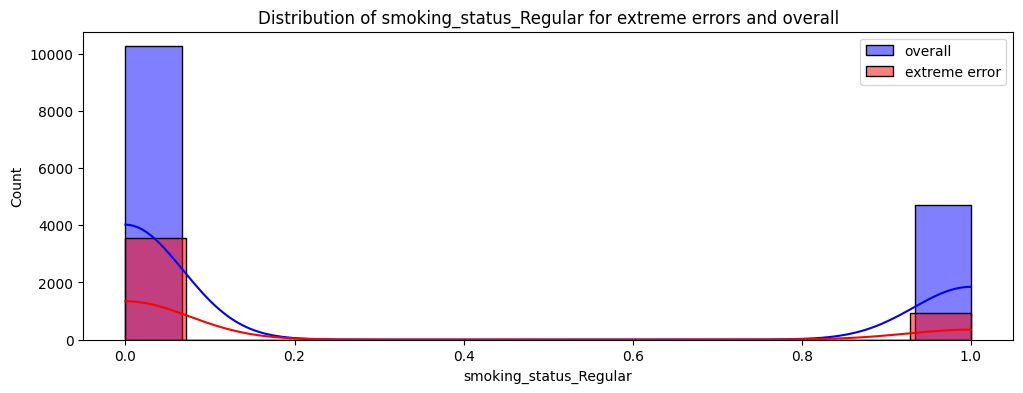

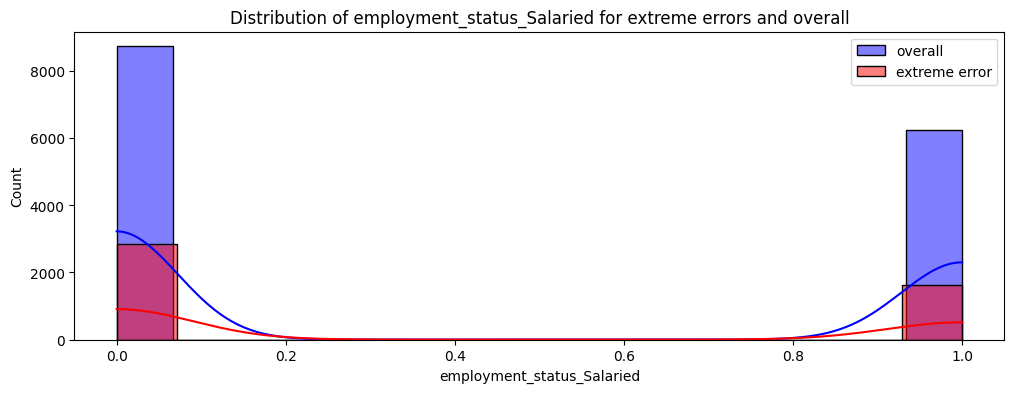

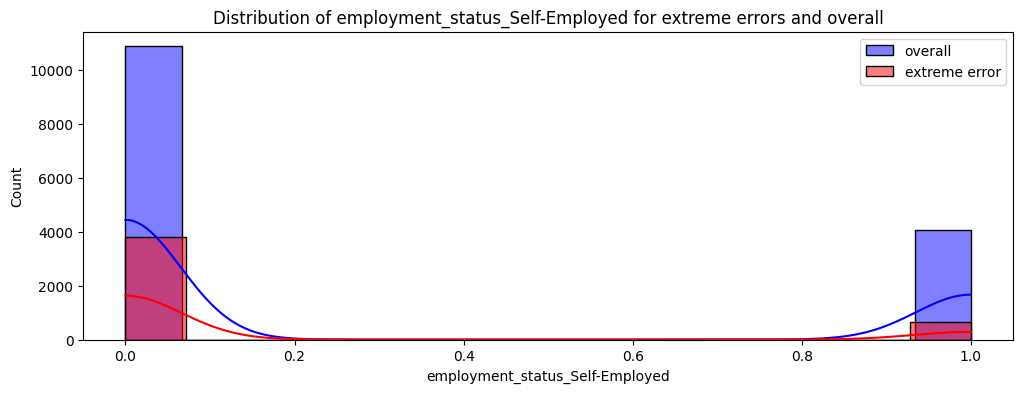

In [275]:
for columns in extreme_errors.columns:
    plt.figure(figsize=(12,4))
    sns.histplot(X_test[columns], label='overall', kde=True, color='blue')
    sns.histplot(extreme_errors[columns],label='extreme error', kde=True, color='red',alpha=0.5)
    plt.legend()
    plt.title(f'Distribution of {columns} for extreme errors and overall')
    plt.show()

In [276]:
extreme_errors.sample(5)

,age,number_of_dependants,income_lakhs,insurance_plan,normalized_risk_score,gender_Male,region_Northwest,region_Southeast,region_Southwest,marital_status_Unmarried,bmi_category_Obesity,bmi_category_Overweight,bmi_category_Underweight,smoking_status_Occasional,smoking_status_Regular,employment_status_Salaried,employment_status_Self-Employed
40546,0.037037,0.0,0.272727,0.0,0.000000,0,1,0,0,1,0,0,1,0,0,1,0
14477,0.037037,0.0,0.080808,0.0,0.000000,0,0,1,0,1,0,0,1,0,0,0,0
23573,0.074074,0.0,0.101010,0.5,0.785714,0,0,1,0,1,0,0,0,0,0,0,0
23979,0.111111,0.4,0.212121,0.0,0.000000,1,0,1,0,1,0,0,0,0,1,1,0
13048,0.000000,0.2,0.454545,0.5,0.000000,1,0,0,1,1,0,0,0,1,0,1,0


##  Reverse scaling

In [278]:
col_to_scale=cols
col_to_scale

['age',
 'number_of_dependants',
 'income_level',
 'income_lakhs',
 'insurance_plan']

In [281]:
extreme_errors['income_level']=-1

In [288]:
extreme_errors=scaler.inverse_transform(extreme_errors[col_to_scale])
extreme_errors_df=pd.DataFrame(extreme_errors_df, columns=col_to_scale)
extreme_errors_df

,age,number_of_dependants,income_level,income_lakhs,insurance_plan
0,25.0,1.0,-2.0,64.0,3.0
1,22.0,0.0,-2.0,2.0,1.0
2,24.0,0.0,-2.0,43.0,3.0
3,20.0,0.0,-2.0,30.0,1.0
4,24.0,0.0,-2.0,61.0,2.0
...,...,...,...,...,...
4461,25.0,2.0,-2.0,25.0,1.0
4462,19.0,2.0,-2.0,18.0,1.0
4463,24.0,1.0,-2.0,3.0,1.0
4464,41.0,3.0,-2.0,32.0,2.0


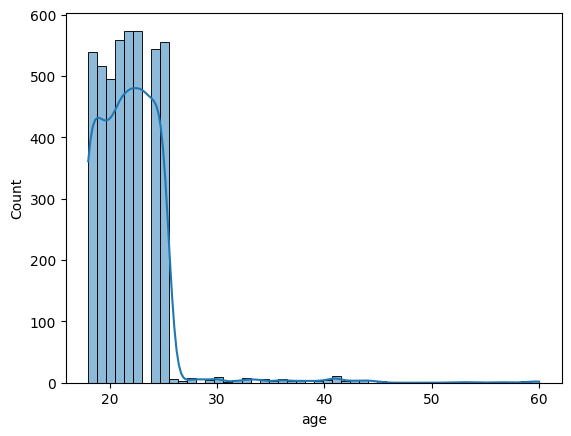

In [306]:
sns.histplot(extreme_errors_df['age'], kde=True, bins=50)
plt.show()

In [305]:
print(f"25th percentile--->{extreme_errors_df.age.quantile(0.25)}")
print(f"50th percentile--->{extreme_errors_df.age.quantile(0.50)}")
print(f"75th percentile--->{extreme_errors_df.age.quantile(0.75)}")
print(f"95th percentile--->{extreme_errors_df.age.quantile(0.95)}")
print(f"97th percentile--->{extreme_errors_df.age.quantile(0.97)}")
print(f"98th percentile--->{extreme_errors_df.age.quantile(0.98)}")
print(f"99th percentile--->{extreme_errors_df.age.quantile(0.99)}")
print(f"100th percentile--->{extreme_errors_df.age.quantile(1)}")

25th percentile--->20.0
50th percentile--->22.0
75th percentile--->24.0
95th percentile--->25.0
97th percentile--->25.0
98th percentile--->28.0
99th percentile--->38.0
100th percentile--->60.00000000000001


Most of the errors are coming from young age group whose age less than 25. We may need to build separate model for this.